# Visualizing Overfitting and Model Complexity

In [1]:
import os
# Set environment variables because cvxopt might hang otherwise
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

import sys

from dataclasses import dataclass
from typing import Union

from AppliedML.courselib.utils.metrics import accuracy, mean_squared_error
from AppliedML.courselib.utils.preprocessing import labels_encoding
from AppliedML.courselib.utils.splits import train_test_split
from AppliedML.courselib.optimizers import GDOptimizer
import datagen.ConcentricBands as cc
import datagen.HalfMoons as hm
import datagen.Spirals as sp
import datagen.SeparatedBlobs as sb
import datagen.Postprocessors as pp

from models.TunableModel import TunableModel
from models.TunableNN import TunableNN
from models.TunableKernelSVM import TunableKernelSVM
from models.TunableRandomForest import TunableRandomForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
@dataclass
class ExperimentConfig:
    tunable_model: TunableModel
    train_df: pd.DataFrame
    test_df: pd.DataFrame
    training_params: Union[dict, callable]
    encode_label: callable
    title_generator: callable
    measure_accuracy: callable
    random_seed: int
    show_metrics_history: bool = False

In [3]:
def train_tunable_model(cf):
    np.random.seed(cf.random_seed)
    
    models = cf.tunable_model.fit(
        X = cf.train_df[['x', 'y']].to_numpy(),
        y = cf.encode_label(cf.train_df['label']),
        training_params = cf.training_params,
    )

    models = [{"i": i, "model": model, "params": params, "metrics_hist": metrics_hist} 
              for i, model, params, metrics_hist in models]
    models.sort(key=lambda model: model["i"])

    for model in models:
        model["acc_train"] = cf.measure_accuracy(model["model"], cf.train_df)
        model["acc_test"] = cf.measure_accuracy(model["model"], cf.test_df)
    
    has_metrics = len([model["metrics_hist"] for model in models if model["metrics_hist"] is not None]) > 0
    if not has_metrics or not cf.show_metrics_history:
        return models
    
    fig, axs = plt.subplots(1, len(models), figsize=(8*len(models), 8))
    if len(models) == 1:
        axs = np.array([axs])
        
    for ax, model in zip(axs.flat, models):
        ax.set_title(cf.title_generator(model["params"]))

        metrics_hist = model["metrics_hist"]
        if metrics_hist is None:
            ax.text(0.5, 0.5, "No metrics available", horizontalalignment='center', verticalalignment='center')
            continue
        
        xs = range(len(metrics_hist['accuracy']))
        acc = metrics_hist['accuracy']
        loss = metrics_hist['loss']

        acc_plt = ax.plot(xs, acc, color='orange', label='Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        
        ax2 = ax.twinx()
        loss_plt = ax2.plot(xs, loss, color='blue', label='Loss')
        ax2.set_ylabel('Loss')
        
        plots = acc_plt + loss_plt
        labels = [p.get_label() for p in plots]
        ax.legend(plots, labels, loc='best')
    plt.tight_layout()
    plt.show()
    
    return models

In [4]:
def show_tunable_model(title_generator, train_df, test_df, trained_models):
    fig, axs = plt.subplots(1, len(trained_models), figsize=(8*len(trained_models), 8))
    if len(trained_models) == 1:
        axs = np.array([axs])
        
    df = pd.concat([train_df, test_df])
    
    x_min, x_max = df['x'].min() - 0.5, df['x'].max() + 0.5
    y_min, y_max = df['y'].min() - 0.5, df['y'].max() + 0.5
    
    x_list, y_list = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_list = np.dstack([x_list, y_list])
    
    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    colors = df['label'].astype("category").cat.codes
    
    num_train_samples = len(train_df)
    colors_train = colors[:num_train_samples]
    colors_test = colors[num_train_samples:]
    
    for ax, trained_model in zip(axs.flat, trained_models):
        ax.set_title(title_generator(trained_model["params"]))
        ax.set(aspect="equal")  

        model = trained_model["model"]
        h_list = model(X_list)
        
        ax.text(0.5, -0.1, f"Final train accuracy: {trained_model['acc_train']:.1f}%\n"
                           f"Test accuracy: {trained_model['acc_test']:.1f}%", 
                transform=ax.transAxes, ha='center', va='top', fontsize=12)
    
        ax.contourf(x_list, y_list, h_list, cmap=cmap, alpha=0.3)
        
        ax.scatter(test_df['x'], test_df['y'], c=colors_test, edgecolor='k', alpha=0.6, s=5)
        ax.scatter(train_df['x'], train_df['y'], c=colors_train, edgecolor='k')
        
    plt.tight_layout()
    plt.show()

Seed used: 1


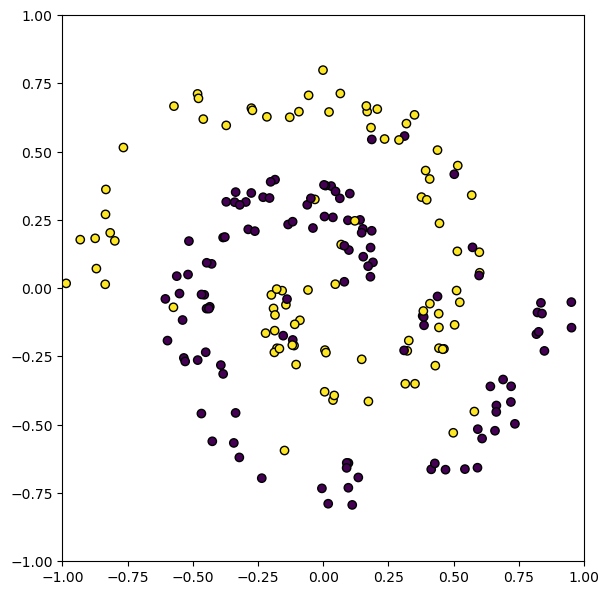

In [5]:
my_seed = 1 #int(random.random()*100000000)
np.random.seed(my_seed)
print("Seed used:", my_seed)

gen = sp.Spirals(sp.SpiralConf(2, 0.2, 0.1, 0.9, 1))
# gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2), width=0.1, angle_range=(0,5.5)),
#                     hm.HalfMoonConf(centre=(0.2,0.2), width=0.1,angle_range=(3.14,3.14+5.5))])
#gen = cc.ConcentricBands()#[cc.CBandConf(0.7, 0.5)])
#gen = sb.RandomSeparatedBlobs()
gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))

def plot_gen(gen, size=6):
    df = gen.sample(num_samples=200)
    
    plt.figure(figsize=(size, size))
    
    colors = df['label'].astype("category").cat.codes
    plt.scatter(df['x'], df['y'], c=colors, edgecolor='k')
    
    plt.tight_layout()
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    
    plt.show()

plot_gen(gen)

## Perceptrons

In [6]:
title_generatorNN = lambda params: f"Width: {params['widths']}"

def trainNN(hyperparameters, test_df, train_df, num_epochs, num_batches, random_seed, show_metrics_history=True):
    tunable_model = TunableNN(hyperparameters=hyperparameters)
    
    training_params = {
        'num_epochs': num_epochs,
        'batch_size': (len(train_df)) // num_batches,
        'compute_metrics': True,
        'metrics_dict': {'accuracy': accuracy, 'loss': mean_squared_error}
    }

    encode_label = lambda ls: labels_encoding(ls.to_numpy())
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model.decision_function(data[['x', 'y']].to_numpy()), 
            encode_label(data['label'])
        )
        
    configNN = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=training_params,
        encode_label=encode_label,
        title_generator=title_generatorNN,
        measure_accuracy=measure_accuracy,
        random_seed=random_seed,
        show_metrics_history=show_metrics_history
    )
    
    return train_tunable_model(configNN)

Fitting 2 models with 2 processes.
Model 0: Done | Model 1: Done



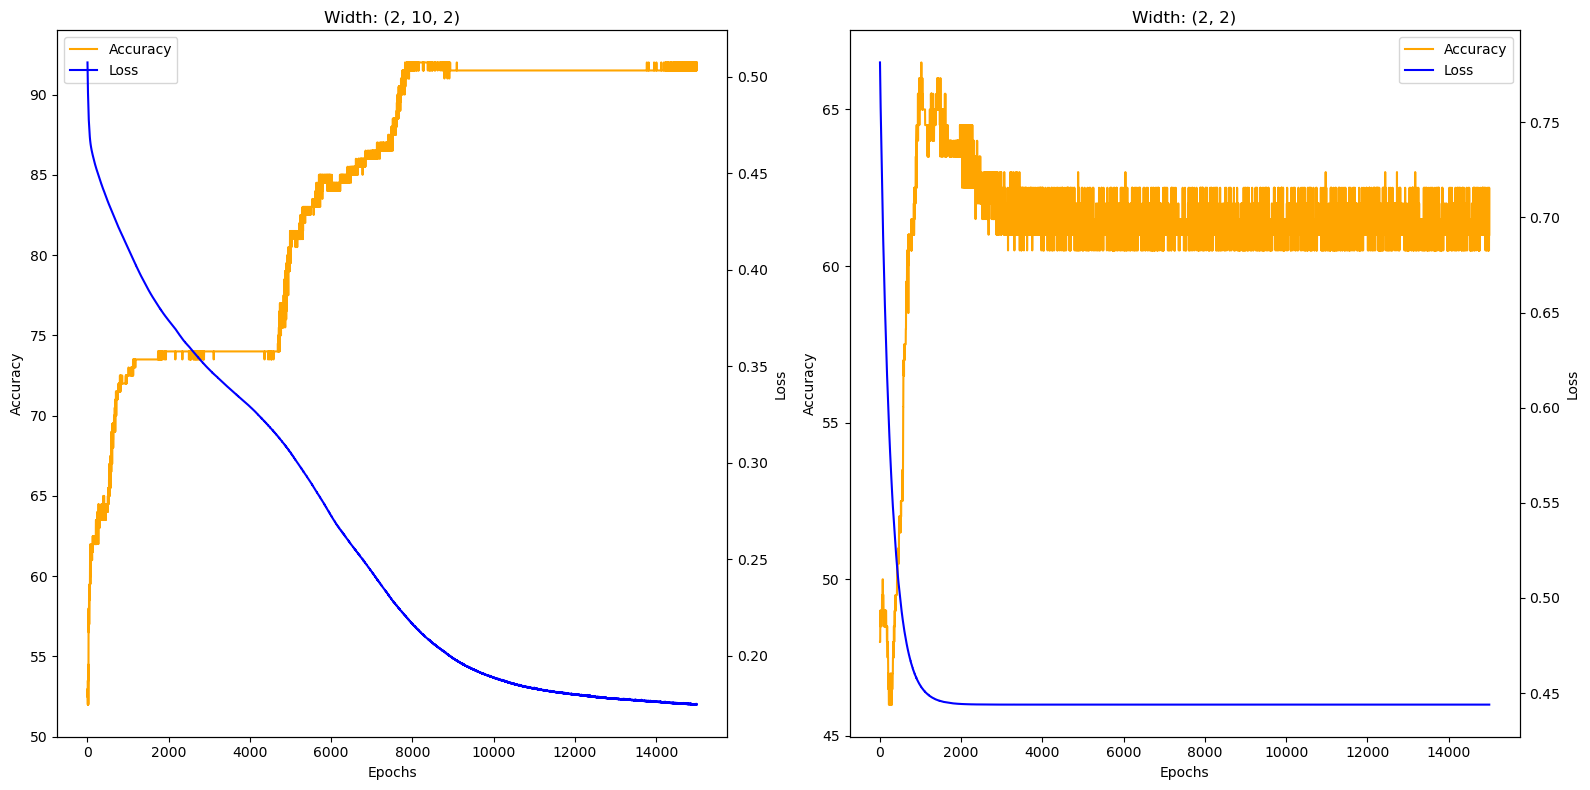

In [7]:
train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

params = {
    'widths': list(map(lambda x: (2,)+(10,)*x+(2,), [1,0])),
    'activation': ["ReLU"],
    'optimizer': GDOptimizer(learning_rate=0.5)
}

trained_models = trainNN(params, train_df=train_df, test_df=test_df, num_epochs=3000, num_batches = 5, random_seed=5)

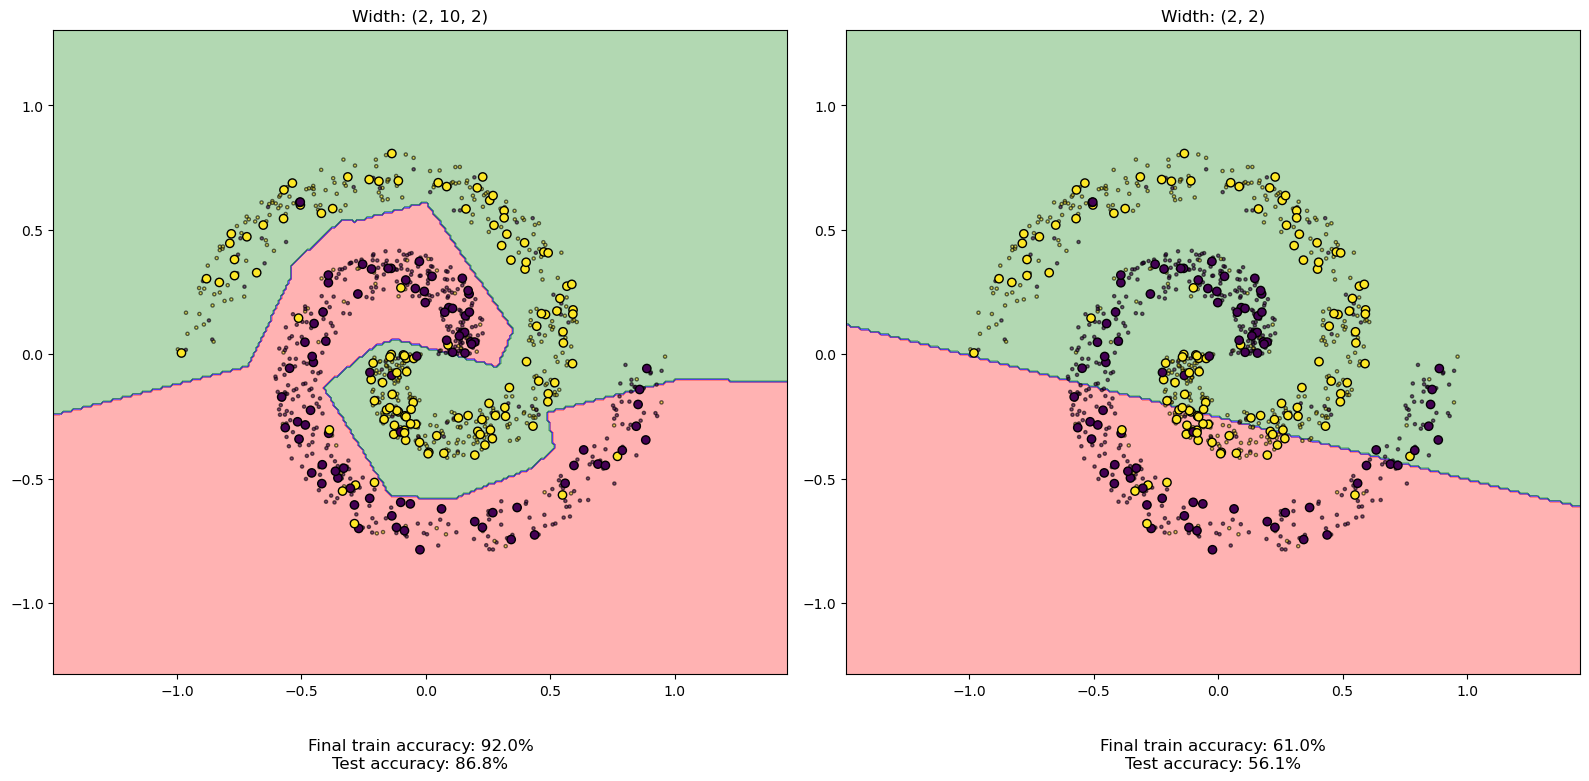

In [8]:
show_tunable_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN,trained_models=trained_models)

## Kernel SVM

In [9]:
title_generatorKernelSVM = lambda params: f"Sigma: {params['sigma']}"

def trainKernelSVM(hyperparameters, test_df, train_df, random_seed):    
    tunable_model = TunableKernelSVM(hyperparameters=hyperparameters)
    
    encode_label = lambda ls: ls.astype("category").cat.codes.to_numpy() * 2 - 1
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model(data[['x', 'y']].to_numpy()), 
            encode_label(data['label']),
            one_hot_encoded_labels=False
        )
        
    configKernelSVM = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=None,
        title_generator=title_generatorKernelSVM,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=1
    )

    return train_tunable_model(configKernelSVM)

In [10]:
params = {
    'kernel': ['rbf'],
    'sigma': [0.01,0.03,0.1,0.4,1],
    'degree': range(1),
    'intercept': range(3),
}
    
train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=2000),
    training_data_fraction=train_split,
    return_numpy=False
)

trained_models = trainKernelSVM(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 5 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done



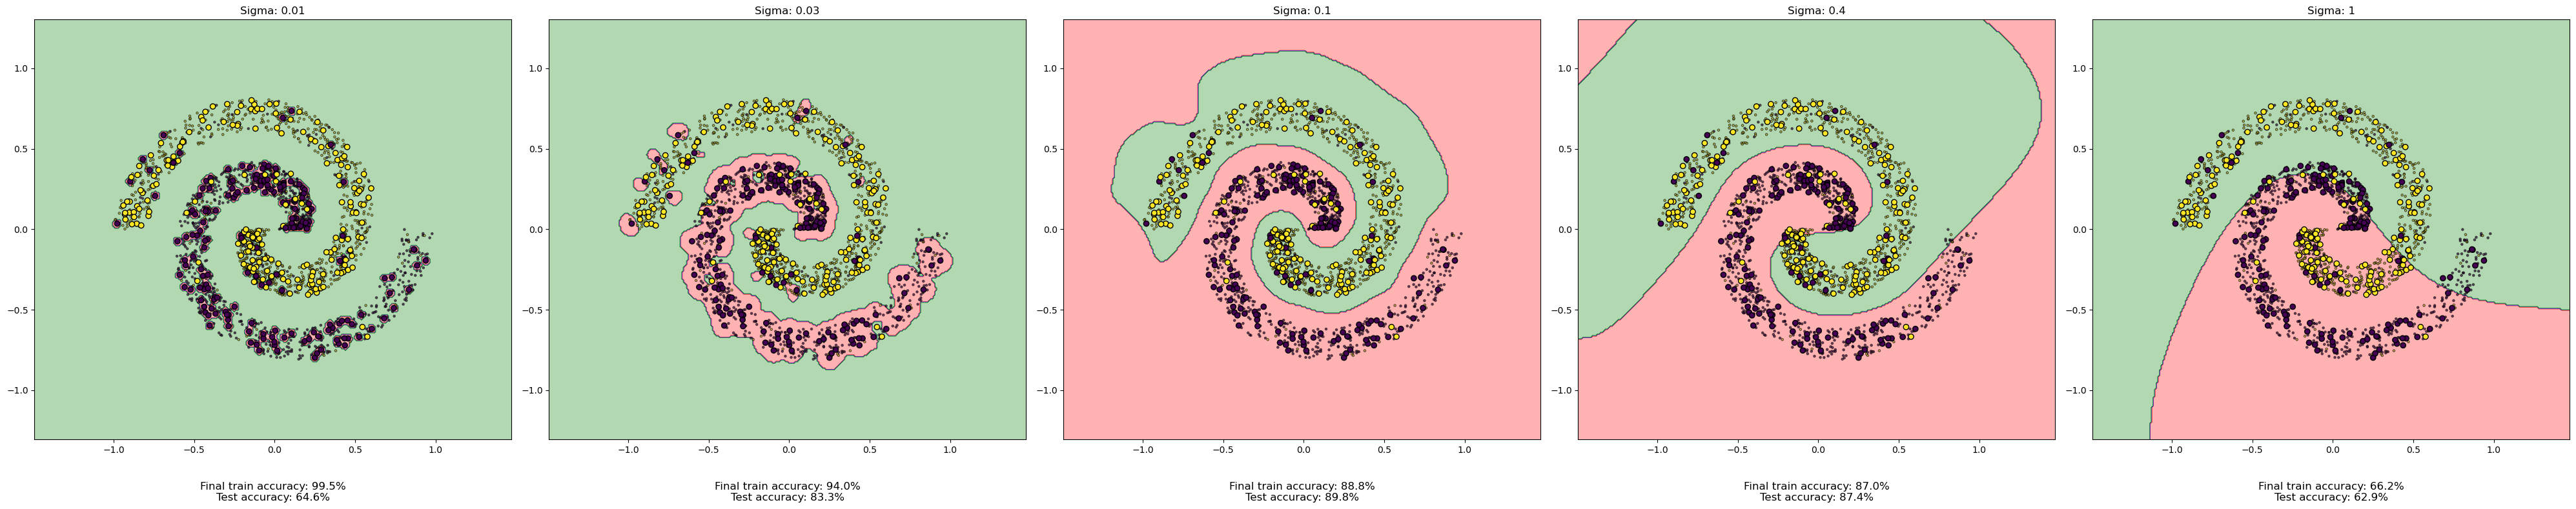

In [11]:
show_tunable_model(train_df=train_df, test_df=test_df, title_generator=title_generatorKernelSVM, trained_models=trained_models)

## Decision Trees

In [12]:
title_generator_forest = lambda params: f"Estimators: {params['n_estimators']}, Depth: {params['max_depth']}"

def trainForest(hyperparameters, test_df, train_df, random_seed):    
    tunable_model = TunableRandomForest(hyperparameters=hyperparameters)
    
    encode_label = lambda ls: ls.to_numpy()
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model.decision_function(data[['x', 'y']].to_numpy()), 
            encode_label(data['label']),
            one_hot_encoded_labels=False
        )
        
    configTrees = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=None,
        title_generator=title_generator_forest,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=1
    )

    return train_tunable_model(configTrees)

In [13]:
params = {
    'n_estimators': [20],
    'max_depth': [1,2,4,8,16,32,64],
    'min_samples_split': 2,
    'max_features': None
}

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

trained_models = trainForest(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 7 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done



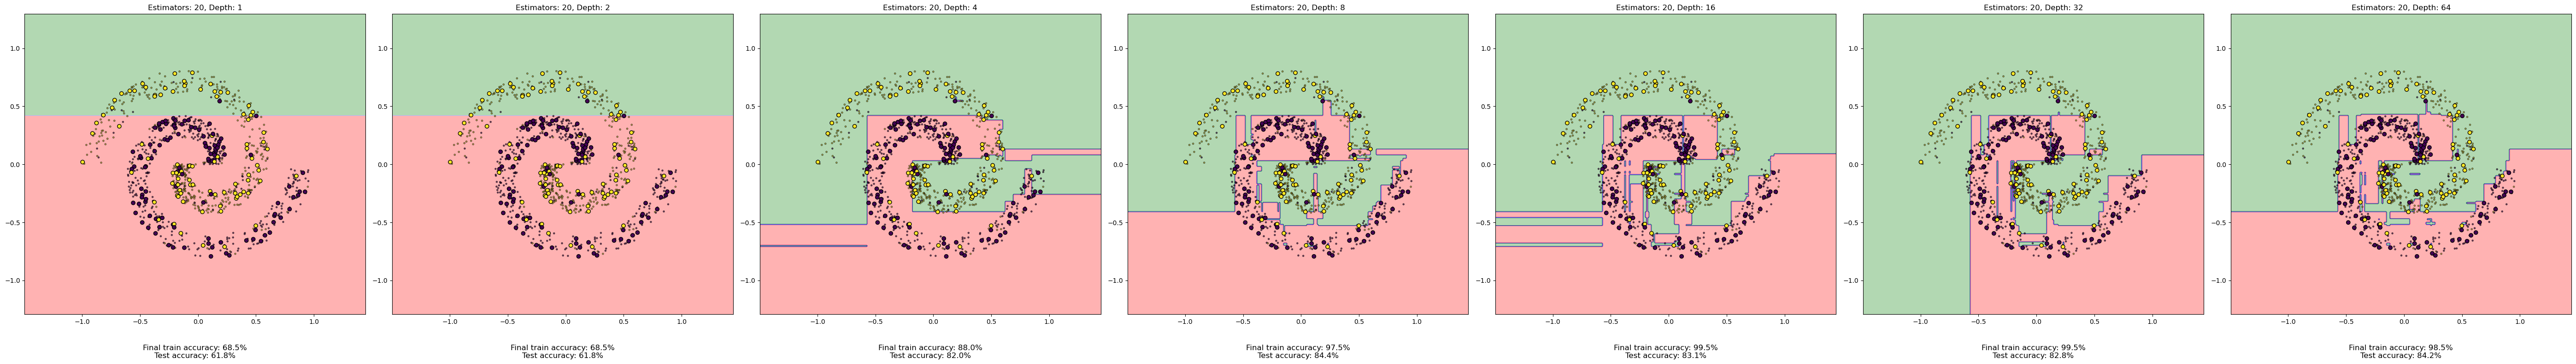

In [14]:
show_tunable_model(train_df=train_df, test_df=test_df, title_generator=title_generator_forest, trained_models=trained_models)

## Final Analysis

In [15]:
class BiasVarianceTradeoff:
    def __init__(self, train_df, test_df, min_cpx, max_cpx, steps_cpx):
        self.train_df = train_df
        self.test_df = test_df
        self.min_cpx = min_cpx
        self.max_cpx = max_cpx
        self.steps_cpx = steps_cpx
    
    def trainNN_with_cpx(self):
        print(f"Training NN")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["NN"], dtype=int)[::-1]
        params = {
            #'widths': list(map(lambda x: (2,)+(10,)*int(2**x-1)+(2,), complexity_range)),
            'widths': list(map(lambda x: (2,int(5**x),2), complexity_range)),
            'activation': ["ReLU"],
            'optimizer': GDOptimizer(learning_rate=0.3)
        }
    
        return (complexity_range,
                trainNN(params, 
                        train_df=self.train_df,
                        test_df=self.test_df,
                        num_epochs=7000,
                        num_batches=1,
                        random_seed=5,
                        show_metrics_history=False))
    
    def trainKernelSVM_with_cpx(self):
        print(f"Training SVM")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["SVM"], 10)[::-1]
        print(complexity_range)
        params = {
            'kernel': ['rbf'],
            'sigma': list(map(lambda x: (0.25)**x, complexity_range)),
            'degree': range(1),
            'intercept': range(3),
        }
        
        return complexity_range, trainKernelSVM(params, test_df=self.test_df, train_df=self.train_df, random_seed=5)
    
    def trainForest_with_cpx(self):
        print(f"Training Forest")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["Forest"], 10)[::-1]
        params = {
            'n_estimators': [20],
            'max_depth': list(map(lambda x: int(4**x), complexity_range)),
            'min_samples_split': 2,
            'max_features': None
        }
        
        return complexity_range, trainForest(params, test_df=self.test_df, train_df=self.train_df, random_seed=5)

    
    def plot_model_accuracy(self, res, ax, model_name):
        complexity_range, trained_models = res
        trained_models.sort(key=lambda x: x["i"])
        #show_tunable_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN,trained_models=trained_models)
        test_plot = ax.plot(complexity_range,
                           list(map(lambda x: x["acc_test"], trained_models)),
                           label=f"{model_name} Test Acc.")
        color = test_plot[0].get_color()
        ax.plot(complexity_range,
                list(map(lambda x: x["acc_train"], trained_models)),
                linestyle='--',                
                color=color,
                label=f"{model_name} Train Acc.")

    def plot(self):
        fig, ax = plt.subplots()
    
        self.plot_model_accuracy(self.trainNN_with_cpx(), ax=ax, model_name="NN")
        self.plot_model_accuracy(self.trainKernelSVM_with_cpx(), ax=ax, model_name="SVM")
        self.plot_model_accuracy(self.trainForest_with_cpx(), ax=ax, model_name="Forest")
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,100)
        ax.set_xlabel('Complexity')
        
        plt.title('Bias-variance tradeoff.')
        plt.legend()
        plt.grid()

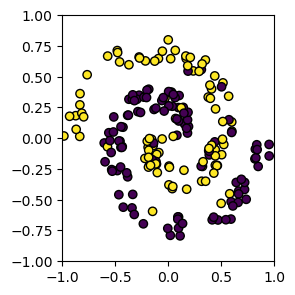

Training NN
Fitting 10 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training SVM
[4.         3.55555556 3.11111111 2.66666667 2.22222222 1.77777778
 1.33333333 0.88888889 0.44444444 0.        ]
Fitting 10 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training Forest
Fitting 10 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done



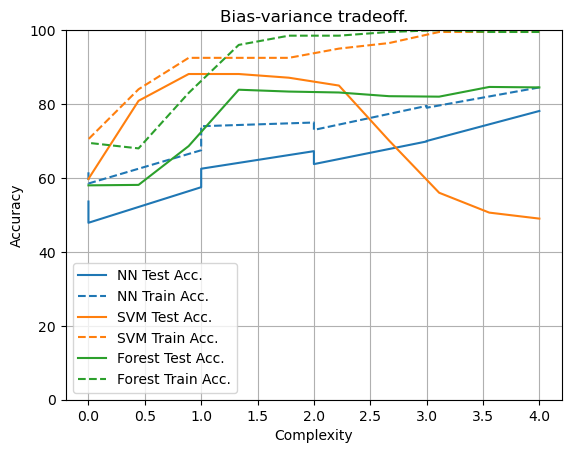

In [17]:
np.random.seed(1)
gen = sp.Spirals(sp.SpiralConf(2, 0.2, 0.1, 0.9, 1))
gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
plot_gen(gen, size=3)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

BiasVarianceTradeoff(train_df=train_df, test_df=test_df, min_cpx=0, max_cpx=4, steps_cpx={"NN": 10, "SVM": 10, "Forest": 10}).plot()

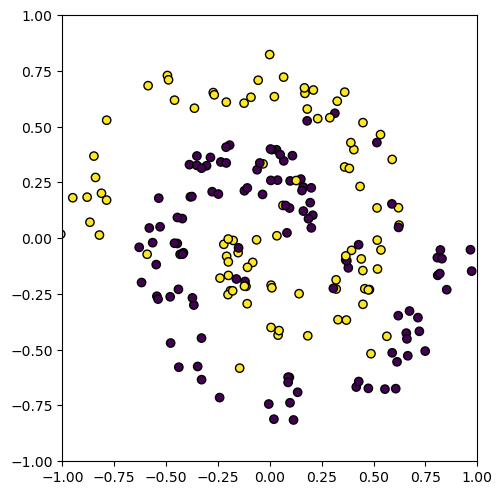

In [20]:
np.random.seed(1)
gen = sp.Spirals(sp.SpiralConf(2, 0.25, 0.1, 0.9, 1))
gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
plot_gen(gen, size=5)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

#BiasVarianceTradeoff(train_df=train_df, test_df=test_df, min_cpx=0, max_cpx=4, steps_cpx={"NN": 10, "SVM": 10, "Forest": 10}).plot()
